These data represent daily energy measurements of 3 factories monitoring systems and published by Schneider Electric.

https://shop.exchange.se.com/en-US/apps/39121/factories-daily-energy-consumption/overview

This data was supported with three additional datasets:

metadata offering location information and general descriptive features of the meters,
a holiday dataset summarizing the occurrences of regional public holidays,
historical weather data containing temperature relative to the building’s location in a time series format.
For our analysis, we merged these 4 data sets together on the meter id for energy related data and on the date and time stamp for holiday and weather data. We narrowed down our dataset to focus on detecting anomalies in energy usage for one laboratory meter located at Site 38. Our data consisted of 49,000 rows and contained information from years 2012–2016.

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
import pandas as pd

In [2]:
pd.set_option('display.max_columns', 500)
train = pd.read_csv("/content/train.csv")

In [3]:
test = pd.read_csv("/content/test.csv")

In [4]:
X = pd.concat([train, test])
# Convert 'date' column to datetime type
X['Timestamp'] = pd.to_datetime(X['Timestamp'])

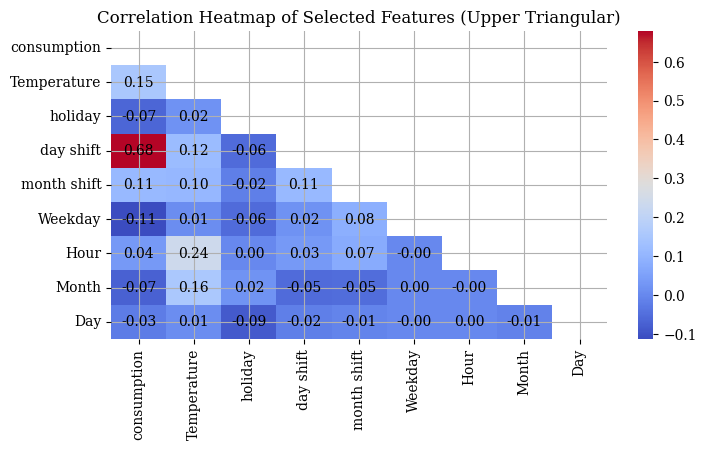

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

X.rename({'tv delta': 'consumption'}, axis=1, inplace= True)
correlation_matrix = X[['consumption', 'Temperature', 'holiday', 'day shift','month shift', 'Weekday', 'Hour', 'Month', 'Day']].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0,
            annot_kws={"color": 'black'})
plt.title('Correlation Heatmap of Selected Features (Upper Triangular)')
plt.grid('False')
plt.show()

the strong correlations can be seen with 'prev value', 'twice prev value', and 'day shift', suggesting that these variables are influential in determining the values of 'tv delta'.

## Descriptive statistics

In [6]:
X[['consumption', 'Temperature', 'holiday', 'month shift', 'Weekday', 'Hour', 'Month', 'Day']].describe()

,consumption,Temperature,holiday,month shift,Weekday,Hour,Month,Day
count,49001.000000,49001.00000,49001.000000,49001.000000,49001.000000,49001.000000,49001.000000,49001.000000
mean,129.251563,12.17877,0.028591,129.881047,3.005694,11.496194,6.512336,15.611702
std,48.926223,8.40994,0.166656,59.051481,1.997322,6.922477,3.383160,8.822523
min,0.000000,-12.60000,0.000000,-5095.000000,0.000000,0.000000,1.000000,1.000000
25%,100.000000,5.70000,0.000000,100.000000,1.000000,5.000000,4.000000,8.000000
50%,123.500000,12.20000,0.000000,124.000000,3.000000,11.000000,7.000000,16.000000
75%,151.000000,18.10000,0.000000,153.000000,5.000000,17.000000,9.000000,23.000000
max,425.000000,37.70000,1.000000,5095.000000,6.000000,23.000000,12.000000,31.000000


This statistical summary provides us some insight into the observations which were identified as outliers. Firstly, as evident by the maximum metrics (5095), most-likely data-entry errors.

In [7]:
# Filter out extreme values
X_clean = X[(X['month shift'] != -5095) & (X['month shift'] != 5095)]
X_clean[['consumption', 'Temperature', 'holiday', 'month shift', 'Weekday', 'Hour', 'Month', 'Day']].describe()

,consumption,Temperature,holiday,month shift,Weekday,Hour,Month,Day
count,48999.000000,48999.000000,48999.000000,48999.000000,48999.000000,48999.000000,48999.000000,48999.000000
mean,129.251900,12.178995,0.028592,129.886348,3.005694,11.496480,6.512235,15.611523
std,48.927193,8.410037,0.166660,49.263941,1.997362,6.922473,3.383192,8.822659
min,0.000000,-12.600000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,100.000000,5.700000,0.000000,100.000000,1.000000,5.000000,4.000000,8.000000
50%,123.500000,12.200000,0.000000,124.000000,3.000000,11.000000,7.000000,16.000000
75%,151.000000,18.100000,0.000000,153.000000,5.000000,17.000000,9.000000,23.000000
max,425.000000,37.700000,1.000000,425.000000,6.000000,23.000000,12.000000,31.000000


- Sudden changes in 'prev value', 'twice prev value', 'day shift', and 'month shift' (e.g., large standard deviations, extreme minimum or maximum values) might indicate important shifts or anomalies in the data.
- The presence of negative values in 'prev value', 'twice prev value', 'day shift', and 'month shift' might require investigation, especially if these variables represent quantities that should only be positive.

In [8]:
X_clean_cat= X[['prev value', 'twice prev value', 'day shift', 'month shift']]
X_clean_cat.describe()

,prev value,twice prev value,day shift,month shift
count,49001.000000,49001.000000,49001.000000,49001.000000
mean,129.147770,129.252400,129.271318,129.881047
std,54.317999,58.766009,58.797585,59.051481
min,-5095.000000,-5095.000000,-5095.000000,-5095.000000
25%,100.000000,100.000000,100.000000,100.000000
50%,123.500000,123.500000,123.000000,124.000000
75%,151.000000,151.000000,151.000000,153.000000
max,425.000000,5095.000000,5095.000000,5095.000000


In [9]:
# Filter out rows with -5095 and 5095 in 'prev value', 'twice prev value', 'day shift', and 'month shift'
X_clean_cat = X[(X['prev value'] != -5095) & (X['prev value'] != 5095) &
                  (X['twice prev value'] != -5095) & (X['twice prev value'] != 5095) &
                  (X['day shift'] != -5095) & (X['day shift'] != 5095) &
                  (X['month shift'] != -5095) & (X['month shift'] != 5095)]

# Describe the relevant columns again
X_clean_cat[['prev value', 'twice prev value', 'day shift', 'month shift']].describe()

,prev value,twice prev value,day shift,month shift
count,48995.000000,48995.000000,48995.000000,48995.000000
mean,129.262575,129.263248,129.281005,129.886584
std,48.915519,48.916447,48.955221,49.265645
min,0.000000,0.000000,0.000000,0.000000
25%,100.000000,100.000000,100.000000,100.000000
50%,124.000000,124.000000,123.000000,124.000000
75%,151.000000,151.000000,151.000000,153.000000
max,425.000000,425.000000,425.000000,425.000000


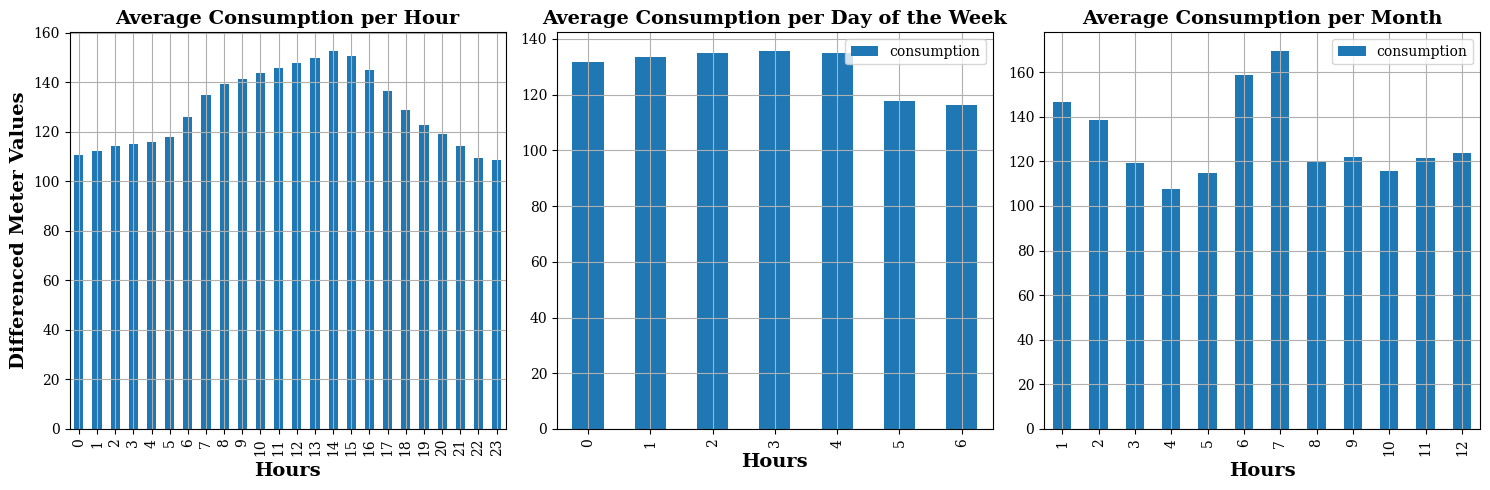

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Average consumption per hour
X_clean.groupby('Hour')['consumption'].mean().plot(kind='bar', ax=axs[0])
axs[0].set_title('Average Consumption per Hour', fontsize=14)
axs[0].set_xlabel('Hours', fontweight='bold', fontsize=14)
axs[0].title.set_fontweight('bold')

# Average consumption per day of the week
X_clean[['Weekday', 'consumption']].groupby(['Weekday']).mean().plot(kind='bar', ax=axs[1])
axs[1].set_title('Average Consumption per Day of the Week', fontsize=14)
axs[1].set_xlabel('Hours', fontweight='bold', fontsize=14)
axs[1].title.set_fontweight('bold')

# Average consumption per month
X_clean[['Month', 'consumption']].groupby(['Month']).mean().plot(kind='bar', ax=axs[2])
axs[2].set_title('Average Consumption per Month', fontsize=14)
axs[0].set_ylabel('Differenced Meter Values', fontweight='bold', fontsize=14)
axs[2].set_xlabel('Hours', fontweight='bold', fontsize=14)
axs[2].title.set_fontweight('bold')
plt.tight_layout()
plt.show()


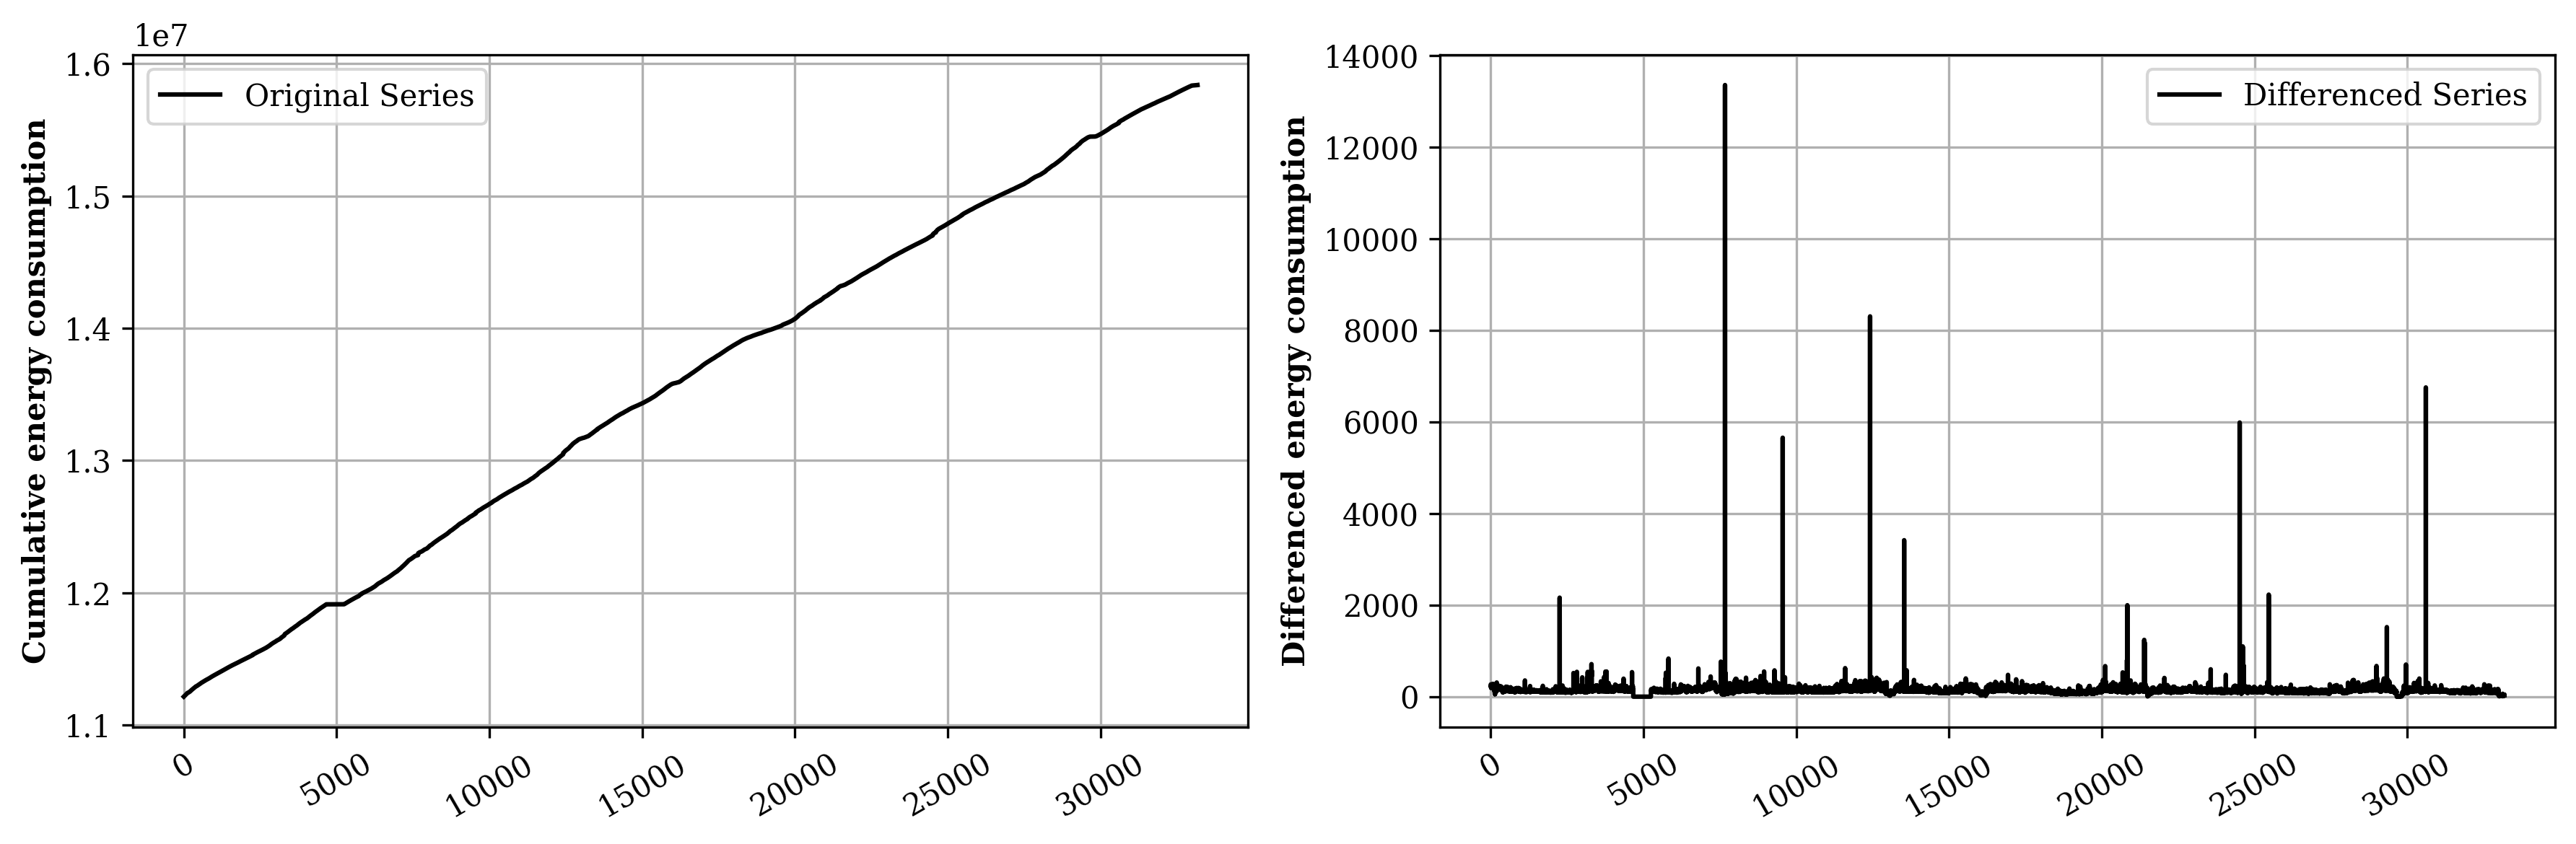

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

df = train.copy()
# Differencing to make the series stationary
df['energy_diff'] = df['Values'].diff()

# Plot the original and differenced series
plt.figure(figsize=(12, 4), dpi=300)
plt.subplot(1, 2, 1)
plt.plot(df['Values'], color='k', label='Original Series')
plt.legend()
plt.xticks(rotation=30)
plt.ylabel('Cumulative energy consumption', weight='bold')

plt.subplot(1, 2, 2)
plt.plot(df['energy_diff'], color='k', label='Differenced Series')
plt.legend()
plt.xticks(rotation=30)
plt.ylabel('Differenced energy consumption', weight='bold')

plt.tight_layout()
plt.show()


<ipython-input-12-3225136a1d3e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_clean['workday'] = X_clean.apply(lambda row: row['Weekday'] < 5, axis=1)


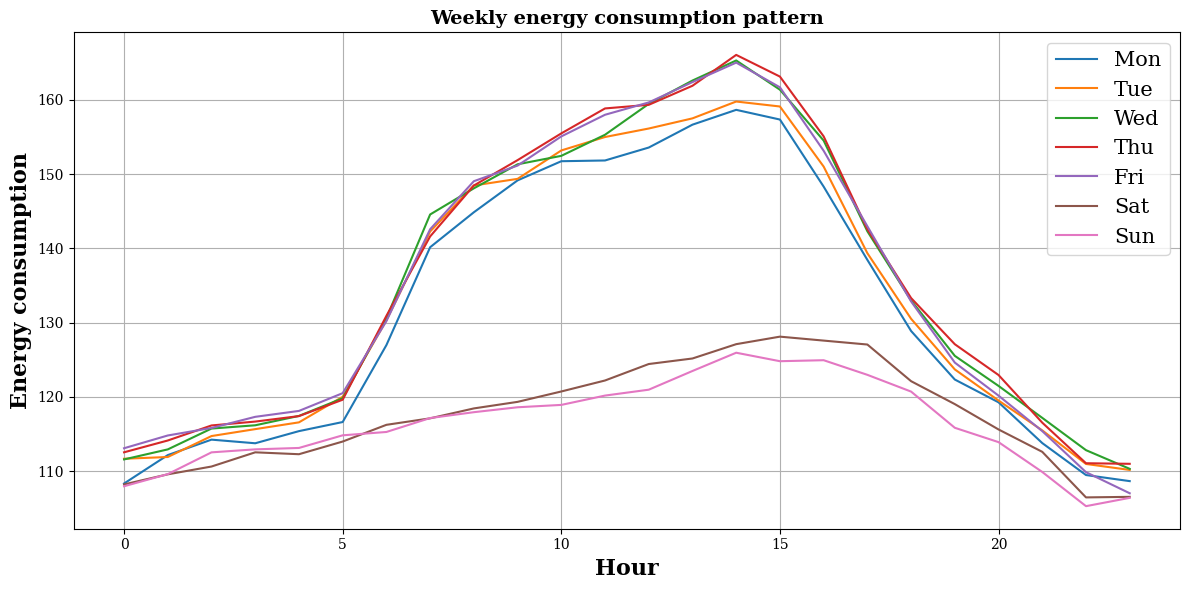

In [12]:
X_clean['workday'] = X_clean.apply(lambda row: row['Weekday'] < 5, axis=1)
df_day_hour = X_clean[['consumption', 'Weekday', 'Hour', 'workday']].groupby(['Weekday', 'Hour']).mean()
df_day_hour = df_day_hour.reset_index()
weekday_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

fig, ax = plt.subplots(figsize=(12, 6))
# Plot for all days (Monday to Sunday)
for idx, label in enumerate(weekday_labels):
    ax.plot(df_day_hour[df_day_hour['Weekday'] == idx].reset_index()['consumption'], label=label)

ax.set_title('Weekly energy consumption pattern', fontweight='bold', fontsize=14)  # Set title for the plot
ax.legend(fontsize=15)

ax.set_xlabel('Hour', fontweight='bold', fontsize=16)
ax.set_ylabel('Energy consumption', fontweight='bold', fontsize=16)

plt.tight_layout()
plt.show()

In [13]:
X_clean.head(2)

,Unnamed: 0.1,Unnamed: 0,Timestamp,Values,Temperature,holiday,Weekday,Hour,Month,Day,Time Delta,value delta,consumption,prev value,twice prev value,day shift,month shift,year,pred,workday
0,0,721,2012-01-31 06:00:00+00:00,11213381.0,0.3,0,1,6,1,31,1.0,224.0,224.0,203.0,215.0,205.0,97.0,2012,216.70,True
1,1,722,2012-01-31 07:00:00+00:00,11213635.0,0.2,0,1,7,1,31,1.0,254.0,254.0,224.0,203.0,242.0,107.0,2012,242.11,True


<ipython-input-14-97c3698e5b30>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=30, fontsize=16)


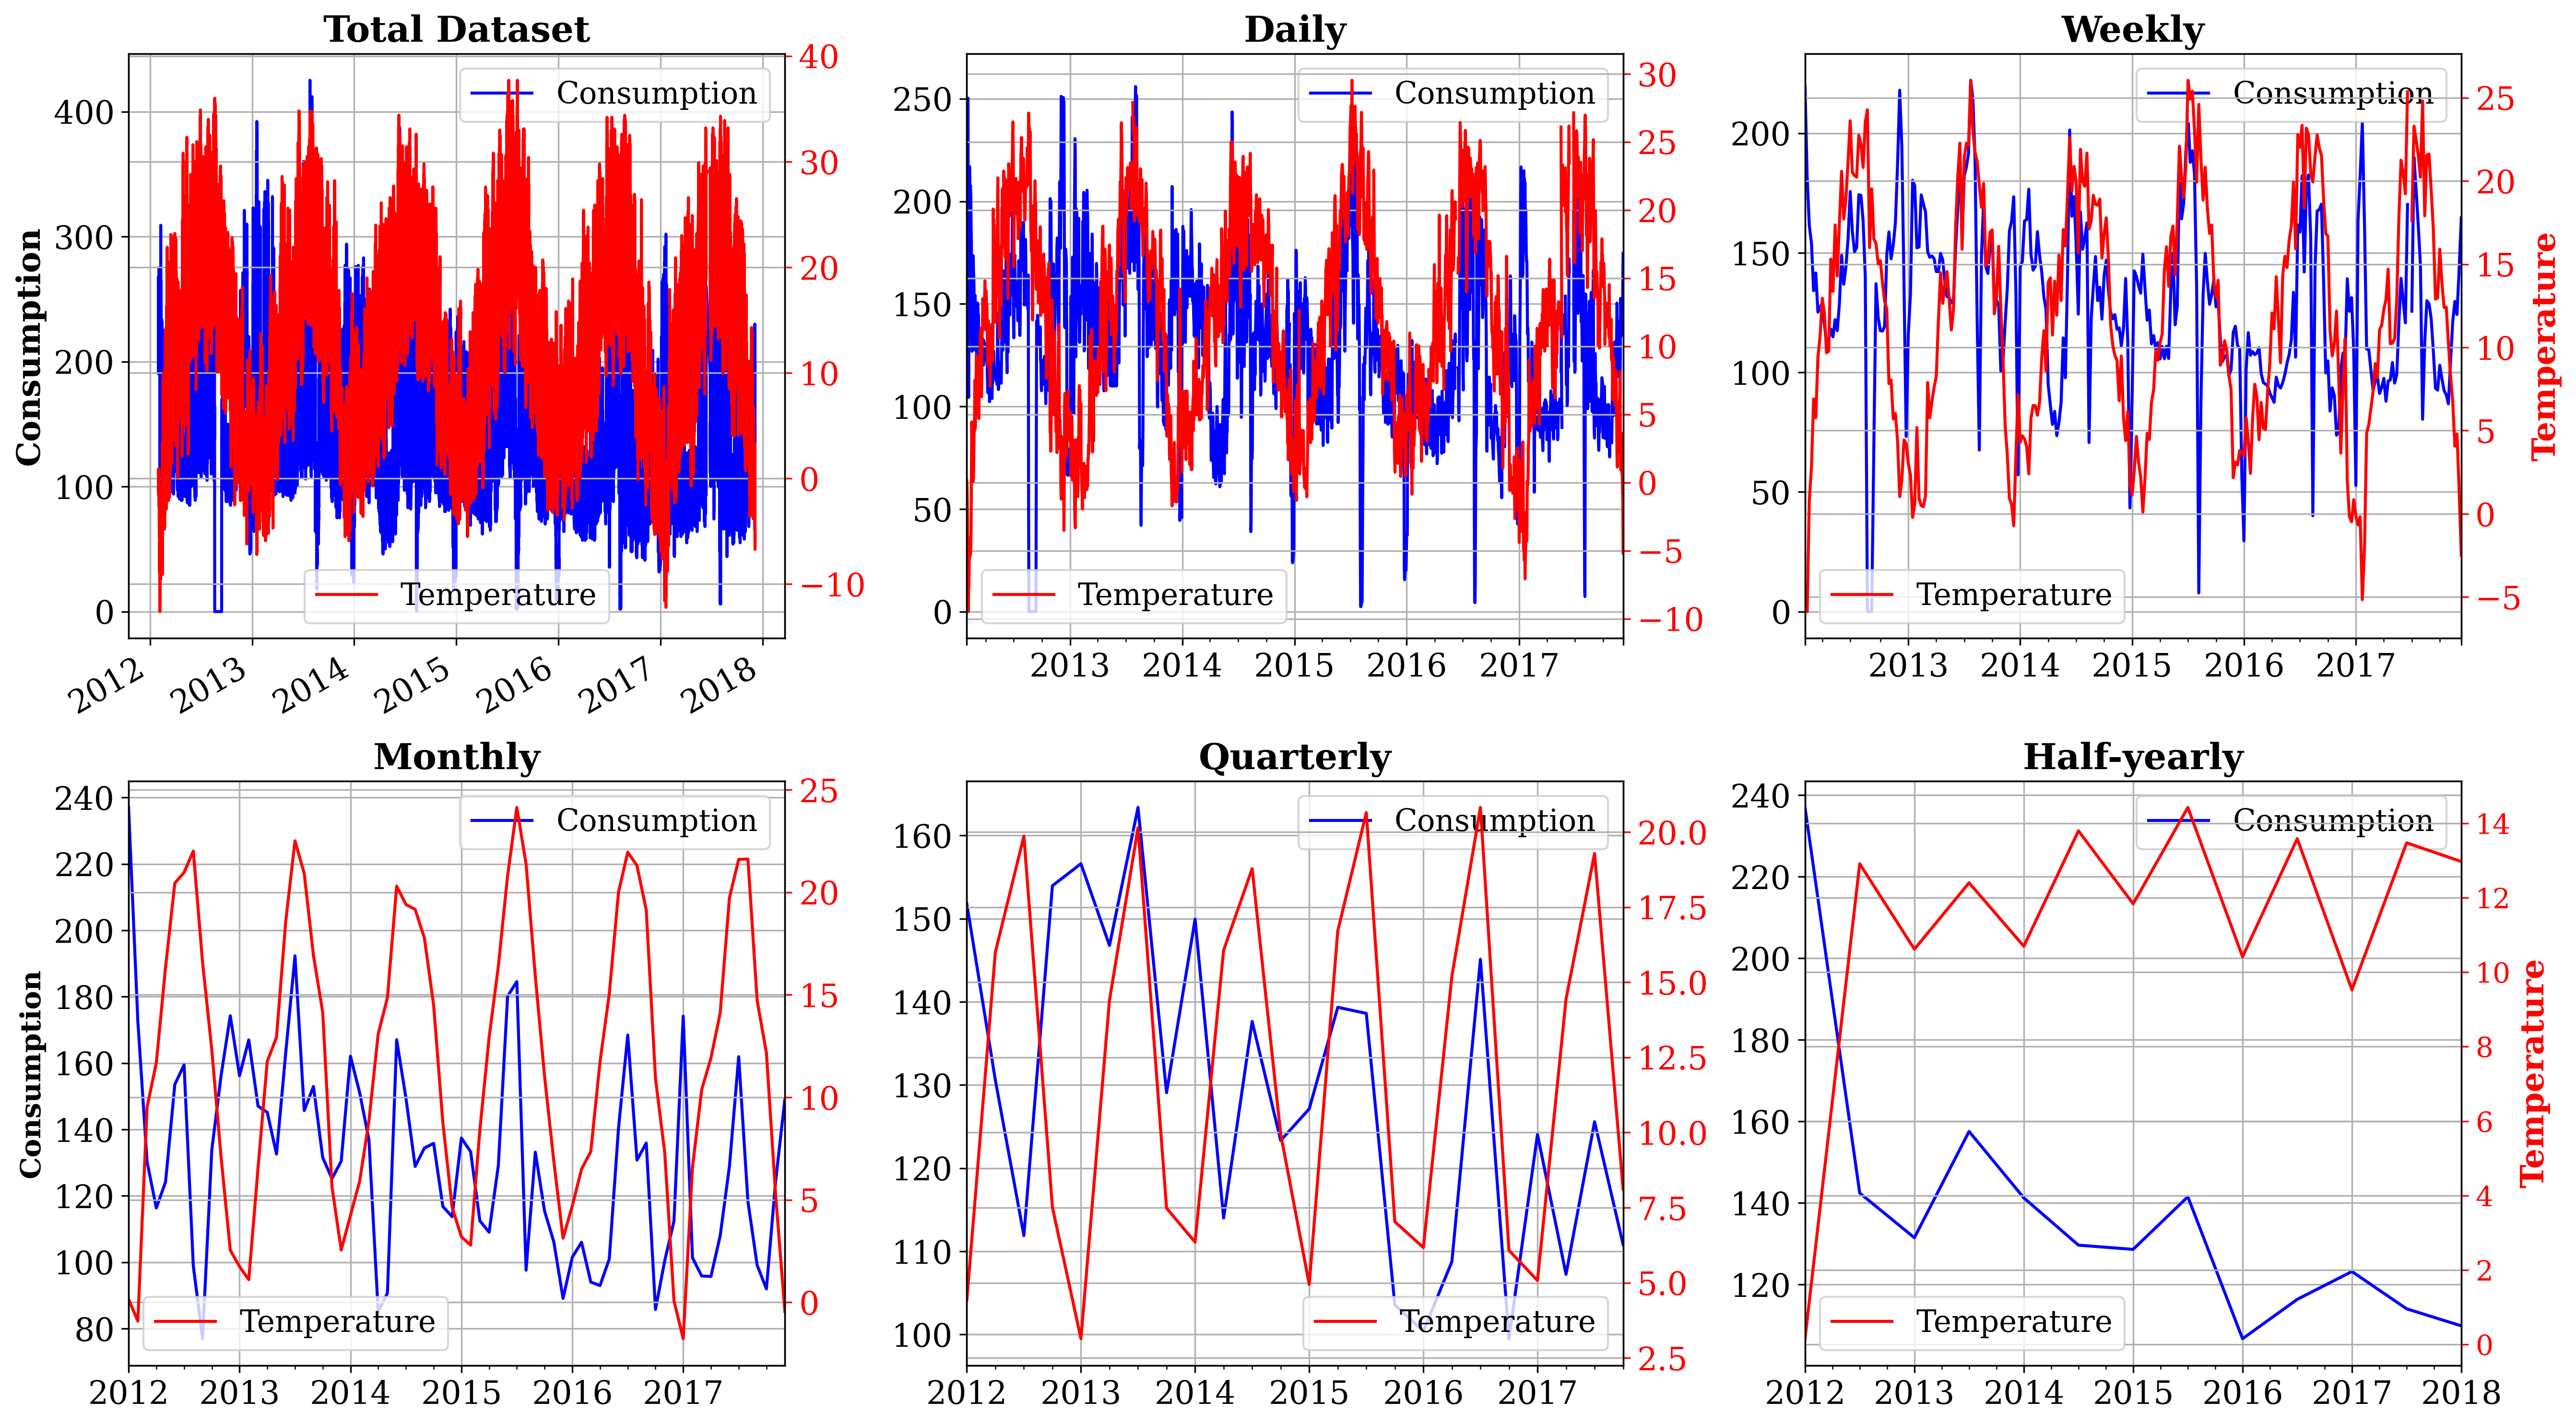

In [14]:
from matplotlib import pyplot as plt
import pandas as pd

# Convert index to datetime format
X_clean.set_index("Timestamp", inplace=True)

# Create subplots with 2 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(18, 10), dpi=300)

# Plot 1: Total dataset
ax1 = axs[0, 0]
X_clean['consumption'].plot(kind='line', ax=ax1,  color='blue',title='Total Dataset', fontsize=16, label='Consumption')
ax1.set_ylabel('Consumption', fontweight='bold', fontsize=16)
ax1.title.set_fontweight('bold')
ax1.title.set_fontsize(18)
ax1.legend(fontsize=15)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=30, fontsize=16)
ax1.set_xlabel('')

ax2 = ax1.twinx()
X_clean['Temperature'].plot(kind='line', ax=ax2, color='red', fontsize=16, label='Temperature')
# ax2.set_ylabel('Temperature', fontweight='bold', fontsize=14, color='red')
ax2.legend(fontsize=15)
ax2.tick_params(axis='y', colors='red')
ax2.set_xlabel('')

# Plot 2: 7 days dataset
ax3 = axs[0, 1]
X_clean['consumption'].resample('D').mean().plot(ax=ax3,  color='blue',title='Daily', fontsize=16, label='Consumption')
ax3.title.set_fontweight('bold')
ax3.title.set_fontsize(18)
ax3.legend(fontsize=15)
ax3.set_xlabel('')

ax4 = ax3.twinx()
X_clean['Temperature'].resample('D').mean().plot(ax=ax4, color='red', fontsize=16, label='Temperature')
ax4.legend(fontsize=15)
ax4.tick_params(axis='y', colors='red')
ax4.set_xlabel('')

# Plot 3: 1 day dataset
ax5 = axs[0, 2]
X_clean['consumption'].resample('W').mean().plot(ax=ax5,  color='blue',title='Weekly', fontsize=16, label='Consumption')
ax5.title.set_fontweight('bold')
ax5.title.set_fontsize(18)
ax5.legend(fontsize=15)
ax5.set_xlabel('')

ax6 = ax5.twinx()
X_clean['Temperature'].resample('W').mean().plot(ax=ax6, color='red', fontsize=16, label='Temperature')
ax6.legend(fontsize=15)
ax6.set_ylabel('Temperature', fontweight='bold', fontsize=16, color='red')
ax6.tick_params(axis='y', colors='red')
ax6.set_xlabel('')

# Plot 4: Monthly dataset
ax7 = axs[1, 0]
X_clean['consumption'].resample('M').mean().plot(ax=ax7,  color='blue', title='Monthly', fontsize=16, label='Consumption')
ax7.set_ylabel('Consumption', fontweight='bold', fontsize=14)
ax7.title.set_fontweight('bold')
ax7.title.set_fontsize(18)
ax7.legend(fontsize=15)
ax7.set_xlabel('')

ax8 = ax7.twinx()
X_clean['Temperature'].resample('M').mean().plot(ax=ax8, color='red', fontsize=16, label='Temperature')
ax8.legend(fontsize=15)
ax8.tick_params(axis='y', colors='red')
ax8.set_xlabel('')

# Plot 5: Quarterly dataset
ax9 = axs[1, 1]
X_clean['consumption'].resample('Q').mean().plot(ax=ax9,  color='blue', title='Quarterly', fontsize=16, label='Consumption')
ax9.title.set_fontweight('bold')
ax9.title.set_fontsize(18)
ax9.legend(fontsize=15)
ax9.set_xlabel('')

ax10 = ax9.twinx()
X_clean['Temperature'].resample('Q').mean().plot(ax=ax10, color='red', fontsize=16, label='Temperature')
ax10.legend(fontsize=15)
ax10.tick_params(axis='y', colors='red')
ax10.set_xlabel('')

# Plot 6: Half-yearly dataset
ax11 = axs[1, 2]
X_clean['consumption'].resample('6M').mean().plot(ax=ax11,  color='blue',title='Half-yearly', fontsize=16, label='Consumption')
# ax11.set_ylabel('Consumption', fontweight='bold', fontsize=14)
ax11.title.set_fontweight('bold')
ax11.title.set_fontsize(18)
ax11.legend(fontsize=15)
ax11.set_xlabel('')

ax12 = ax11.twinx()
X_clean['Temperature'].resample('6M').mean().plot(ax=ax12, color='red', fontsize=14, label='Temperature')
ax12.legend(fontsize=15)
ax12.set_ylabel('Temperature', fontweight='bold', fontsize=16, color='red')
ax12.tick_params(axis='y', colors='red')
ax12.set_xlabel('')

plt.tight_layout()
plt.show()

In [15]:
df = X_clean.reset_index().copy()

# Extracting various time components from the Timestamp column
df['Hour'] = df['Timestamp'].dt.hour
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['Quarter'] = df['Timestamp'].dt.quarter
df['Month'] = df['Timestamp'].dt.month
df['Year'] = df['Timestamp'].dt.year
df['DayOfYear'] = df['Timestamp'].dt.dayofyear
df['DayOfMonth'] = df['Timestamp'].dt.day
df['WeekOfYear'] = df['Timestamp'].dt.isocalendar().week  # Using isocalendar().week for week of the year
df['DayOfYearFloat'] = df['DayOfYear'] + df['Hour'] / 24
df.head()


,Timestamp,Unnamed: 0.1,Unnamed: 0,Values,Temperature,holiday,Weekday,Hour,Month,Day,Time Delta,value delta,consumption,prev value,twice prev value,day shift,month shift,year,pred,workday,DayOfWeek,Quarter,Year,DayOfYear,DayOfMonth,WeekOfYear,DayOfYearFloat
0,2012-01-31 06:00:00+00:00,0,721,11213381.0,0.3,0,1,6,1,31,1.0,224.0,224.0,203.0,215.0,205.0,97.0,2012,216.70,True,1,1,2012,31,31,5,31.250000
1,2012-01-31 07:00:00+00:00,1,722,11213635.0,0.2,0,1,7,1,31,1.0,254.0,254.0,224.0,203.0,242.0,107.0,2012,242.11,True,1,1,2012,31,31,5,31.291667
2,2012-01-31 08:00:00+00:00,2,723,11213893.0,0.2,0,1,8,1,31,1.0,258.0,258.0,254.0,224.0,248.0,106.0,2012,257.67,True,1,1,2012,31,31,5,31.333333
3,2012-01-31 09:00:00+00:00,3,724,11214154.0,0.2,0,1,9,1,31,1.0,261.0,261.0,258.0,254.0,242.0,95.0,2012,260.36,True,1,1,2012,31,31,5,31.375000
4,2012-01-31 10:00:00+00:00,4,725,11214422.0,0.4,0,1,10,1,31,1.0,268.0,268.0,261.0,258.0,234.0,103.0,2012,262.94,True,1,1,2012,31,31,5,31.416667


<ipython-input-16-79ef173677a0>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.boxplot(x=df.DayOfWeek, y=df['consumption'], ax=axes[0][0], palette=colors)
<ipython-input-16-79ef173677a0>:6: UserWarning: 
The palette list has fewer values (1) than needed (7) and will cycle, which may produce an uninterpretable plot.
  g = sns.boxplot(x=df.DayOfWeek, y=df['consumption'], ax=axes[0][0], palette=colors)
<ipython-input-16-79ef173677a0>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(dow_labels)
<ipython-input-16-79ef173677a0>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.boxplot(x=df.Month, y=df['consumption'], ax=axes[0][1], palette=colors)
<ipyt

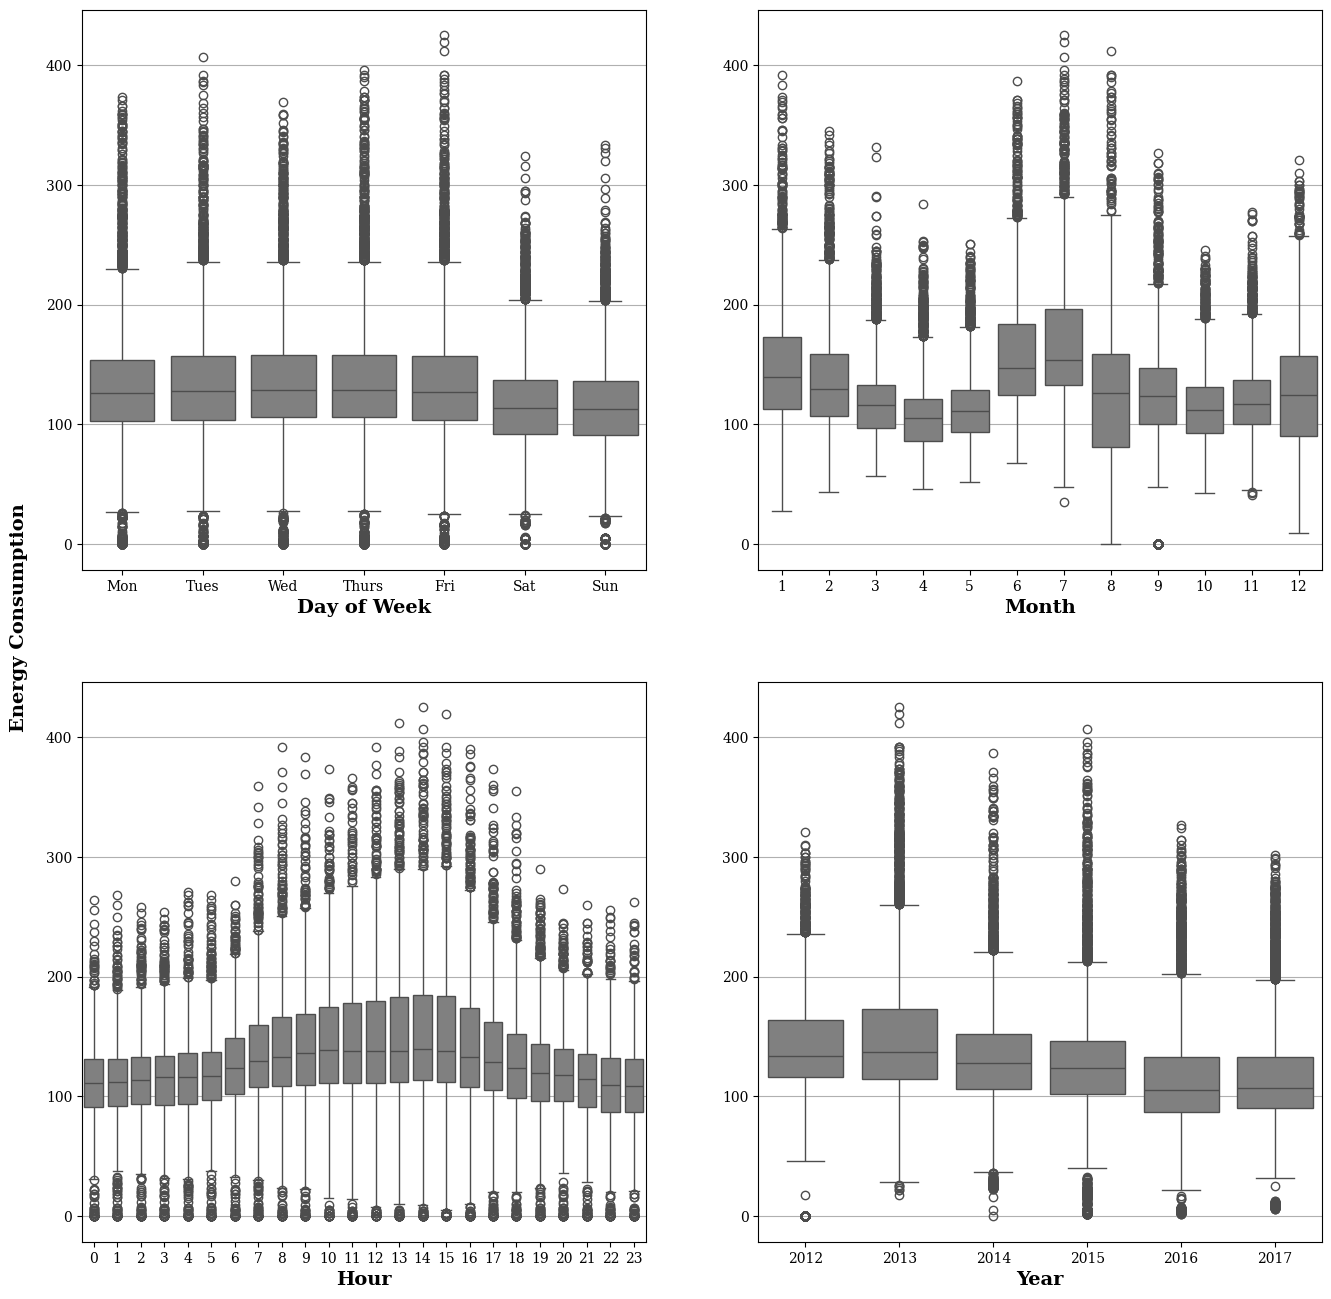

In [16]:
colors = ['gray']
fig, axes = plt.subplots(2, 2, figsize=(16, 16))

# Day of Week
dow_labels = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
g = sns.boxplot(x=df.DayOfWeek, y=df['consumption'], ax=axes[0][0], palette=colors)
g.set_xticklabels(dow_labels)
g.set_ylabel('')
g.set_xlabel('Day of Week', fontweight='bold', fontsize=14)

# Month of Year
g = sns.boxplot(x=df.Month, y=df['consumption'], ax=axes[0][1], palette=colors)
g.set_ylabel('')
g.set_xlabel('Month', fontweight='bold', fontsize=14)

# Hour of Day
g = sns.boxplot(x=df.Hour, y=df['consumption'], ax=axes[1][0], palette=colors)
g.set_ylabel('')
g.set_xlabel('Hour', fontweight='bold', fontsize=14)

# Year
g = sns.boxplot(x=df.Year, y=df['consumption'], ax=axes[1][1], palette=colors)
g.set_ylabel('')
g.set_xlabel('Year', fontweight='bold', fontsize=14)

fig.text(0.08, 0.5, 'Energy Consumption', va='center', rotation='vertical', fontweight='bold', fontsize=14)

plt.show()

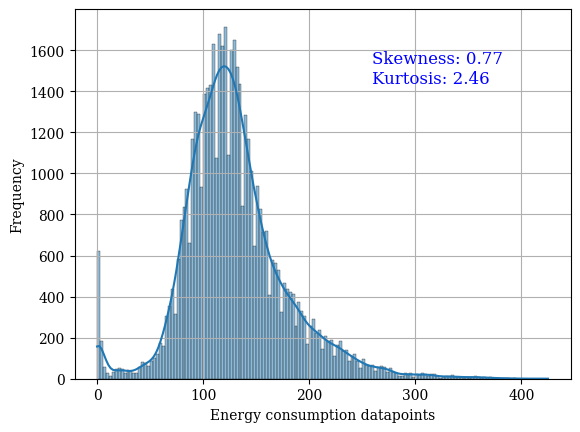

In [17]:
# skewness and kurtosis
skewness = X_clean['consumption'].skew()
kurtosis = X_clean['consumption'].kurt()

sns.histplot(X_clean['consumption'], kde=True)
plt.text(0.6, 0.8, f'Skewness: {skewness:.2f}\nKurtosis: {kurtosis:.2f}',
         transform=plt.gca().transAxes, fontsize=12, color='blue')
plt.xlabel('Energy consumption datapoints')
plt.ylabel('Frequency')
plt.show()


In [18]:
from scipy.stats import kstest

# Kolmogorov-Smirnov test
statistic, p_value = kstest(X_clean['consumption'], 'norm')
print("Kolmogorov-Smirnov Test:")
print("Statistic:", statistic)
print("p-value:", p_value)

alpha = 0.05  # significance level
if p_value > alpha:
    print("The data appears to be normally distributed (fail to reject H0)")
else:
    print("The data does not appear to be normally distributed (reject H0)")

Kolmogorov-Smirnov Test:
Statistic: 0.985955965353337
p-value: 0.0
The data does not appear to be normally distributed (reject H0)


In [19]:
from scipy.stats import anderson

# Anderson-Darling test
result = anderson(X_clean['consumption'])
print("Anderson-Darling Test:")
print("Statistic:", result.statistic)
print("Critical values:", result.critical_values)
print("Significance levels:", result.significance_level)

alpha = 0.05  # significance level
if result.statistic < result.critical_values[2]:
    print("The data appears to be normally distributed at the 5% significance level")
else:
    print("The data does not appear to be normally distributed at the 5% significance level")

Anderson-Darling Test:
Statistic: 677.4151482005254
Critical values: [0.576 0.656 0.787 0.918 1.092]
Significance levels: [15.  10.   5.   2.5  1. ]
The data does not appear to be normally distributed at the 5% significance level
